In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nerf_grasping import nerf_utils, grasp_utils, optimizer_utils
from nerf_grasping.config.camera_config import CameraConfig
from nerf_grasping.config.fingertip_config import EvenlySpacedFingertipConfig
import numpy as np
import pathlib
import pypose as pp
import torch
import nerfstudio

import os
os.chdir("/home/preston/nerf_grasping")


In [29]:
# Set object pose and scale string.
experiment = "2023-09-11_20-52-40"
object_code_and_scale_string = "core-mug-896f1d494bac0ebcdec712af445786fe_0_1104"
nerfcheckpoint_path = list(pathlib.Path(f"data/{experiment}/nerfcheckpoints/{object_code_and_scale_string}").rglob("*.yml"))[0]

grasp_config_dict_path = pathlib.Path("data") / experiment / "evaled_grasp_config_dicts" / f"{object_code_and_scale_string}.npy"
grasp_config_dict = np.load(grasp_config_dict_path, allow_pickle=True).item()
grasp_configs = optimizer_utils.AllegroGraspConfig.from_grasp_config_dict(grasp_config_dict)

# Load a random nerf.
nerf_model = grasp_utils.load_nerf(nerfcheckpoint_path, return_type="model")

# Instantiate a vanilla camera config.
fingertip_config = EvenlySpacedFingertipConfig(
            finger_width_mm=20,
            finger_height_mm=20,
            grasp_depth_mm=50,
            distance_between_pts_mm=0.5,
        )
camera_config = CameraConfig(60, 60)
camera_config.set_intrisics_from_fingertip_config(fingertip_config)

print(camera_config.fy)

# Generate some random cameras.
num_grasps = 2
camera_batch = nerf_utils.get_cameras(grasp_configs[:num_grasps].grasp_frame_transforms.reshape(-1, 7).Inv(), camera_config).to(nerf_model.device)

# Render the nerf.
%time depth, uncertainty = nerf_utils.render(camera_batch, nerf_model, "expected")

/home/preston/miniconda3/envs/nerf_grasping/lib/python3.8/site-packages/pypose/lietensor/lietensor.py:918: UserWarning:

Tensor Shape Invalid by calling <built-in method cat of type object at 0x7fc4f5400820>, go to https://pypose.org/docs/main/generated/pypose.LieTensor



Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
data/2023-09-11_20-52-40/nerfcheckpoints/core-mug-896f1d494bac0ebcdec712af445786fe_0_1104/nerfacto/2023-09-11_232712/ner
fstudio_models/step-000000199.ckpt

150.0
CPU times: user 536 ms, sys: 11.6 ms, total: 548 ms
Wall time: 10.1 ms


In [30]:
far_plane = 2e-1
# nerf_model.proposal_sampler.inital_sampler = nerfstudio.model_components.ray_samplers.UniformLinDispPiecewiseSampler()
depth, uncertainty = nerf_utils.render(camera_batch, nerf_model, "median", far_plane=far_plane)
depth = depth.permute(2, 0, 1).view(-1, 4, camera_config.H, camera_config.W)
uncertainty = uncertainty.permute(2, 0, 1).view(-1, 4, camera_config.H, camera_config.W)




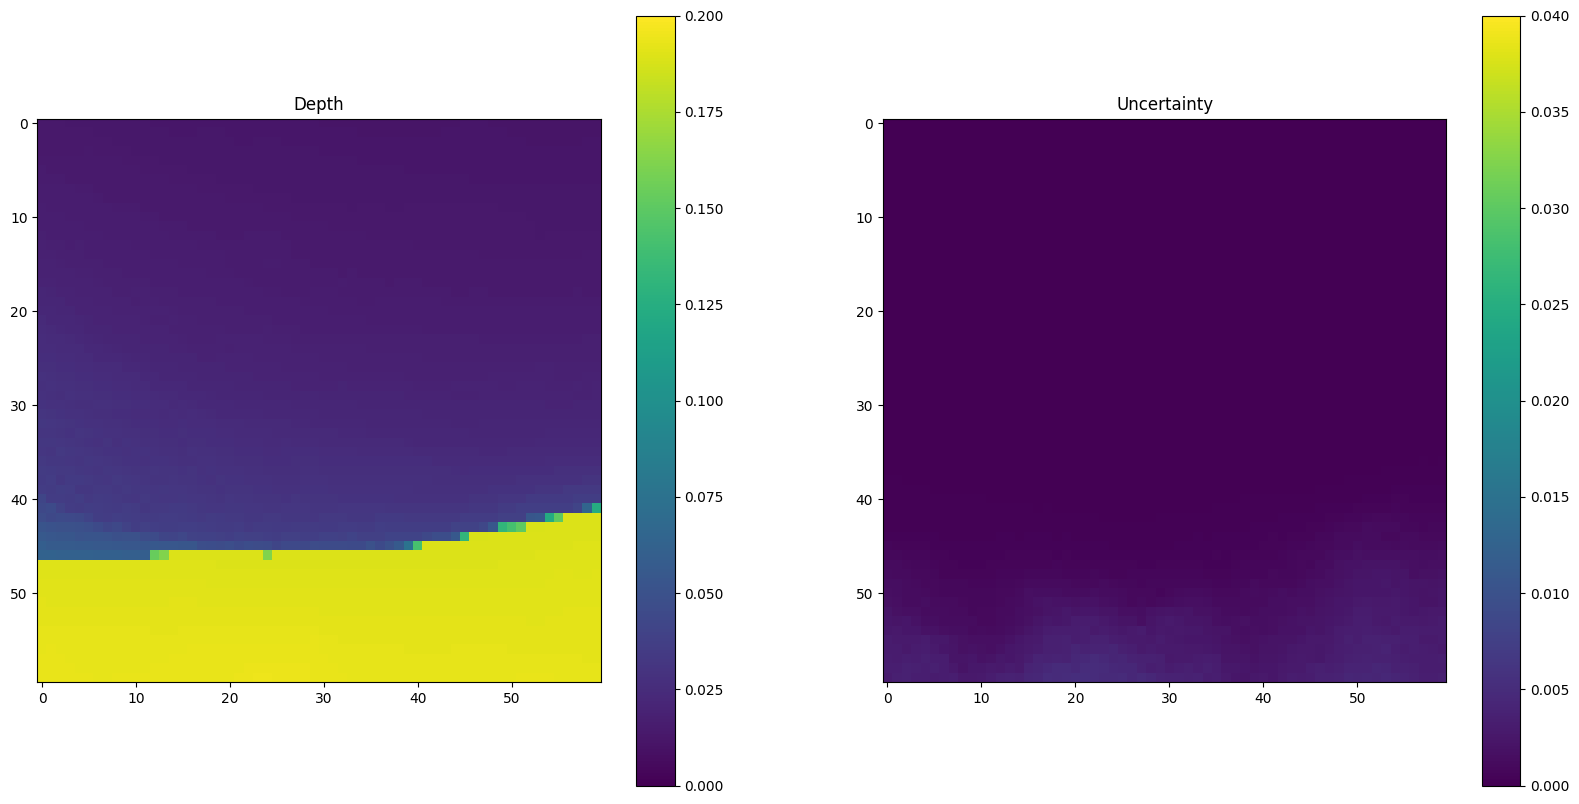

In [31]:
from matplotlib import pyplot as plt
grasp_idx = 0
finger_idx = 0
# plot depth and uncertainty side-by-side
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(depth[grasp_idx, finger_idx].detach().cpu(), vmin=0, vmax=far_plane)
plt.title("Depth")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(uncertainty[grasp_idx, finger_idx].detach().cpu(), vmin=0, vmax=far_plane ** 2)
plt.title("Uncertainty")
plt.colorbar()
plt.show()

In [32]:
ray_samples = nerf_utils.get_ray_samples(camera_batch, nerf_model, near_plane=1e-3, far_plane=far_plane).reshape((camera_config.H, camera_config.W, num_grasps, 4, -1))
sample_points = ray_samples.frustums.get_positions()
sample_points.shape

torch.Size([8])
torch.Size([60, 60, 8])
torch.Size([28800])


torch.Size([60, 60, 2, 4, 48, 3])

Text(0.5, 1.0, 'Depth')

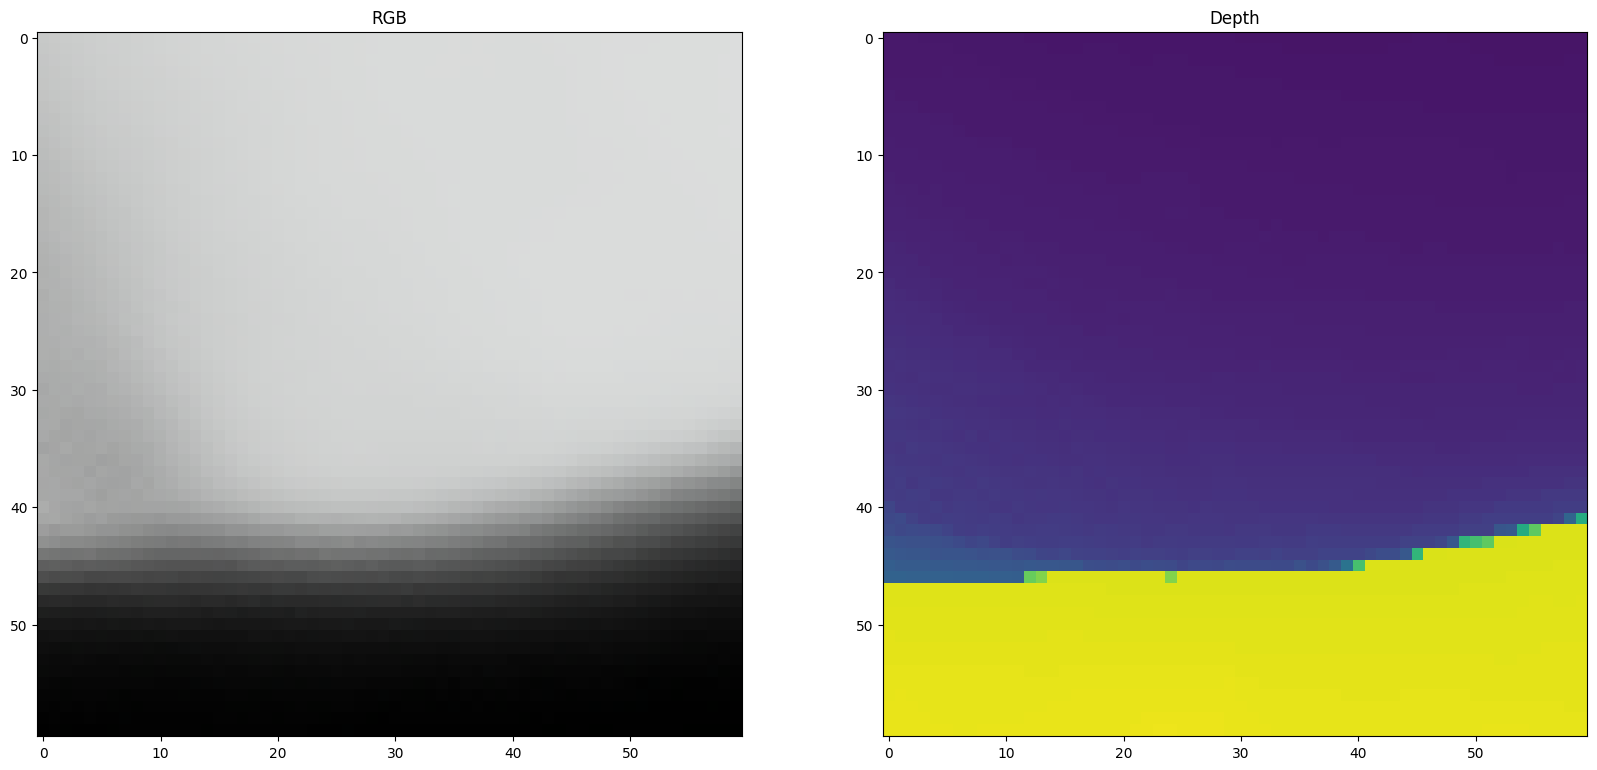

In [33]:
ray_bundle = camera_batch.generate_rays(
        torch.arange(
            camera_batch.camera_to_worlds.shape[0], device=camera_batch.camera_to_worlds.device
        ).unsqueeze(-1),
    )
ray_bundle.nears = torch.ones_like(ray_bundle.pixel_area) * 1e-3
ray_bundle.fars = torch.ones_like(ray_bundle.pixel_area) * far_plane

outputs = nerf_model.get_outputs_for_camera_ray_bundle(ray_bundle)
rgb_image = outputs["rgb"].view(camera_config.H, camera_config.H, -1, 4, 3)
rgb_image = rgb_image.permute(2, 3, 0, 1, 4)
# Show the rgb and depth images
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(rgb_image[grasp_idx, finger_idx].detach().cpu())
plt.title("RGB")

plt.subplot(1, 2, 2)
plt.imshow(depth[grasp_idx, finger_idx].detach().cpu(), vmin=0, vmax=far_plane)
plt.title("Depth")


In [34]:
from nerf_grasping.dataset.DexGraspNet_NeRF_Grasps_utils import plot_mesh_and_transforms, parse_object_code_and_scale
import trimesh

object_code, object_scale = parse_object_code_and_scale(object_code_and_scale_string)

mesh_path = pathlib.Path("data") / "meshdata" / object_code / "coacd" / "decomposed.obj"
mesh = trimesh.load(str(mesh_path))
mesh.apply_scale(object_scale)

# Visualize grasp using our util.
transform = grasp_configs.grasp_frame_transforms[grasp_idx].matrix()
print(f"actual grasp transform: {transform[finger_idx]}")
print(f"camera transform: {camera_batch.camera_to_worlds.reshape(-1, 4, 3, 4)[grasp_idx, finger_idx]}")
transform_list = [transform[ii].detach().numpy() for ii in range(4)]
plot_mesh_and_transforms(mesh, transform_list, 4, highlight_idx=finger_idx)

actual grasp transform: tensor([[-3.8874e-01,  6.4294e-02, -9.1910e-01,  6.6678e-02],
        [ 1.6317e-01,  9.8660e-01, -3.7253e-08, -6.6962e-02],
        [ 9.0678e-01, -1.4997e-01, -3.9402e-01,  4.5698e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       grad_fn=<SelectBackward0>)
camera transform: tensor([[-3.8874e-01,  1.6317e-01,  9.0678e-01, -4.5920e-03],
        [-6.4294e-02, -9.8660e-01,  1.4997e-01,  6.8631e-02],
        [ 9.1910e-01, -5.2154e-08,  3.9402e-01,  7.9290e-02]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [35]:
# Plot mesh and ray samples for a particular grasp.
grasp_idx = 1
finger_idx = 2
query_samples = sample_points[:, :, grasp_idx, finger_idx]
ray_bundle = camera_batch.generate_rays(
        torch.arange(
            camera_batch.camera_to_worlds.shape[0], device=camera_batch.camera_to_worlds.device
        ).unsqueeze(-1),
    )



# h_query = camera_config.H // 2
# w_query = camera_config.W // 2

# Plot grasp and mesh.
from plotly import graph_objects as go
transform = grasp_configs.grasp_frame_transforms[grasp_idx].matrix()
transform_list = [transform[ii].detach().numpy() for ii in range(4)]
fig = plot_mesh_and_transforms(mesh, transform_list, 4, highlight_idx=finger_idx)

for hh in range(0, camera_config.H, 8):
    for ww in range(0, camera_config.W, 8):
        sample_plot = go.Scatter3d(
            x=query_samples[hh, ww, :, 0].detach().cpu(),
            y=query_samples[hh, ww, :, 1].detach().cpu(),
            z=query_samples[hh, ww, :, 2].detach().cpu(),
            mode='markers',
            marker=dict(
                size=2,
                opacity=0.8
            )
        )
        fig.add_trace(sample_plot)


fig.show()